# Main Agent Test Notebook

This notebook tests the new MainAgent with step-by-step execution.

Similar to your friend's implementation but using our existing architecture.

In [19]:
import os
import sys
from pathlib import Path
import logging

# Configure Redis for local development (before other imports)
os.environ['REDIS_URL'] = 'redis://localhost:6379'

# Disable verbose logging
logging.basicConfig(level=logging.WARNING)
logging.getLogger('httpx').setLevel(logging.WARNING)
logging.getLogger('app').setLevel(logging.WARNING)

# Add backend to path
backend_dir = Path.cwd()
if backend_dir.name != 'backend':
    backend_dir = backend_dir / 'backend'
sys.path.insert(0, str(backend_dir))

from dotenv import load_dotenv
load_dotenv()

print("✅ Environment loaded")

✅ Environment loaded


In [22]:
from langchain_openai import ChatOpenAI
from app.agents.main_agent import MainAgent
from langgraph.checkpoint.memory import MemorySaver

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Database path
db_path = backend_dir / "app" / "resource" / "art.db"

print(f"Database: {db_path}")
print(f"Exists: {db_path.exists()}")

Database: e:\Final Year Project\data_exploration_agent\backend\app\resource\art.db
Exists: True


In [ ]:
# Initialize MainAgent
print("Initializing MainAgent...")

agent = MainAgent(
    llm=llm,
    db_path=str(db_path),
    use_postgres_checkpointer=False  # Use MemorySaver for testing
)

print("✅ MainAgent initialized!")
print(f"📊 Graph saved to: {agent.logs_dir}/main_agent_graph.png")

Initializing MainAgent...


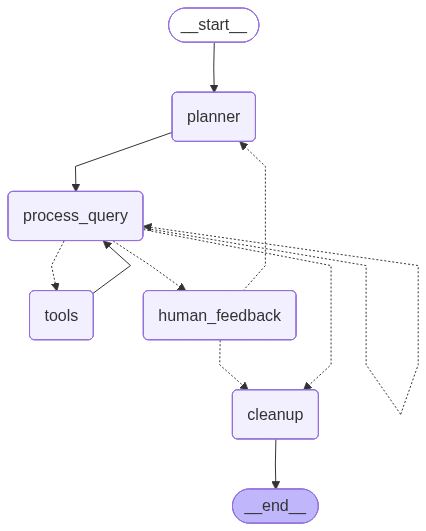

In [13]:
# Display graph
from IPython.display import Image, display

try:
    graph_png = agent.graph.get_graph().draw_mermaid_png()
    display(Image(graph_png))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("Check the PNG file instead")

## Test Queries

Let's test with some queries similar to your friend's examples.

In [14]:
# Test questions
questions = [
    "Which genre has the oldest painting?",
]

print("Test questions:")
for i, q in enumerate(questions, 1):
    print(f"{i}. {q}")

Test questions:
1. Which genre has the oldest painting?


In [15]:
# Setup checkpointer and config
checkpointer = MemorySaver()
config = {
    "configurable": {"thread_id": "test-main-agent"},
    "recursion_limit": 50  # Increase from default 25
}

print("✅ Checkpointer configured")

✅ Checkpointer configured


### Run Query 1

In [ ]:
question = questions[0]
print(f"\n{'='*60}")
print(f"Question: {question}")
print('='*60)

# Stream the execution
for step in agent.graph.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="updates",  # Changed to show only updates
    config=config
):
    # Print node name and key info
    node_name = list(step.keys())[0] if step else "unknown"
    print(f"\n[{node_name}]")
    
    # Show messages if available
    if node_name in step and "messages" in step[node_name]:
        messages = step[node_name]["messages"]
        for msg in messages:
            msg_type = type(msg).__name__
            if hasattr(msg, 'content') and msg.content:
                content = str(msg.content)
                print(f"  {msg_type}: {content}...")
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

print("\n" + "="*60)
print("✅ Query completed!")
print("="*60)


Question: Which genre has the oldest painting?


2025-12-31 14:39:12,009 - app.agents.nodes.planner_node - ERROR - Error in dynamic planning: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_OrTeigmlZ1ABiyNVjBRlJdtk", 'type': 'invalid_request_error', 'param': 'messages.[8].role', 'code': None}}
Traceback (most recent call last):
  File "e:\Final Year Project\data_exploration_agent\backend\app\agents\nodes\planner_node.py", line 293, in _handle_dynamic_planning
    response = structured_llm.invoke(all_messages)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Final Year Project\data_exploration_agent\backend\venv\Lib\site-packages\langchain_core\runnables\base.py", line 3080, in invoke
    input_ = context.run(step.invoke, input_, config, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Final Year Project\data_exploration_ag


[planner]


TypeError: argument of type 'NoneType' is not iterable

### Check State After Execution

In [ ]:
# Get final state
final_state = agent.graph.get_state(config)

print("Final State:")
print(f"  Messages: {len(final_state.values.get('messages', []))}")
print(f"  Steps: {len(final_state.values.get('steps', []))}")
print(f"  Current step index: {final_state.values.get('current_step_index', 0)}")

# Show captured steps
steps = final_state.values.get('steps', [])
if steps:
    print(f"\nCaptured {len(steps)} steps:")
    for step in steps:
        tool_names = step.get('tool_names', [step.get('tool_name', 'unknown')])
        tool_count = step.get('tool_call_count', 1)
        print(f"  Step {step.get('id')}: {tool_names} ({tool_count} tool calls)")

## Summary

The MainAgent:
- ✅ Executes one plan step at a time
- ✅ Allows multiple tool calls per step
- ✅ Captures all tool inputs and outputs
- ✅ Preserves execution history after cleanup
- ✅ Uses existing PlannerNode and state